In [50]:
import sys
sys.path.append('..')

In [51]:
import underworld as uw
from underworld import function as fn
import planetengine
import math
import numpy as np
import random

In [52]:
from planetengine.utilities import quickShow

In [81]:
import underworld as uw
from underworld import function as fn
import math

from planetengine.utilities import Grouper

def build(
        res = 64,
        f = 0.54,
        aspect = 1.,
        length = 1.,
        Ra = 1e7,
        heating = 0.,
        surfT = 0.,
        deltaT = 1.,
        diffusivity = 1.,
        buoyancy = 1.,
        creep = 1.,
        periodic = False,
        segment = 'whole', # 'lower', 'upper', 'middle',
        ):

    ### HOUSEKEEPING: IMPORTANT! ###

    inputs = {key: val for key, val in locals().items() if not key[0] == '_'}
#     script = __file__

    ### MESH & MESH VARIABLES ###

    planetengine.message("Building mesh and variables...")

    f = max(0.00001, min(0.99999, f))
    inputs['f'] = f

    outerRad = - length / (f - 1.)
    midRad = outerRad - (length / 2.)
    radii = (outerRad - length, outerRad)

    maxAspect = 2. * math.pi * midRad / length
    aspect = min(aspect, maxAspect)
    inputs['aspect'] = aspect
    if aspect == maxAspect:
        periodic = True
        inputs['periodic'] = periodic

    width = length**2 * aspect * 2. / (radii[1]**2 - radii[0]**2)
    midpoint = math.pi / 2.
    angExtentRaw = (midpoint - 0.5 * width, midpoint + 0.5 * width)
    angExtentDeg = [item * 180. / math.pi for item in angExtentRaw]
    angularExtent = [
        max(0., angExtentDeg[0]),
        min(360., angExtentDeg[1] + abs(min(0., angExtentDeg[0])))
        ]
    angLen = angExtentRaw[1] - angExtentRaw[0]

    radRes = max(4, int(res / 4) * 4)
    inputs['res'] = radRes
    angRes = max(4, 4 * int(angLen * (int(radRes * radii[1] / length)) / 4))
    elementRes = (radRes, angRes)

    mesh = uw.mesh.FeMesh_Annulus(
        elementRes = elementRes,
        radialLengths = radii,
        angularExtent = angularExtent,
        periodic = [False, periodic]
        )

    temperatureField = uw.mesh.MeshVariable(mesh, 1)
    temperatureDotField = uw.mesh.MeshVariable(mesh, 1)
    pressureField = uw.mesh.MeshVariable(mesh.subMesh, 1)
    velocityField = uw.mesh.MeshVariable(mesh, 2)

    planetengine.message("Mesh and variables built.")

    ### BOUNDARIES ###

    planetengine.message("Making boundary conditions...")
    
    inner = mesh.specialSets["inner"]
    outer = mesh.specialSets["outer"]
    sides = mesh.specialSets["MaxJ_VertexSet"] + mesh.specialSets["MinJ_VertexSet"]

    assert segment in ['lower', 'upper']
    assert periodic == False

    thermalFlux = mesh.add_variable(1)
    thermalFlux.data[:] = 0.
    thermalGradientFn = fn.math.dot(
        temperatureField.fn_gradient,
        mesh.unitvec_r_Fn
        )

    if segment == "upper":
        velBCs = (
            uw.conditions.RotatedDirichletCondition(
                variable = velocityField,
                indexSetsPerDof = (outer + inner, sides),
                basis_vectors = (mesh.bnd_vec_normal, mesh.bnd_vec_tangent)
                ),
            )
        tempBCs = (
            uw.conditions.DirichletCondition(
                variable = temperatureField,
                indexSetsPerDof = (inner + outer,)
                ),
            )
    elif segment == 'lower':
        velBCs = (
            uw.conditions.RotatedDirichletCondition(
                variable = velocityField,
                indexSetsPerDof = (inner, sides + outer),
                basis_vectors = (mesh.bnd_vec_normal, mesh.bnd_vec_tangent)
                ),
            )
        tempBCs = (
            uw.conditions.DirichletCondition(
                variable = temperatureField,
                indexSetsPerDof = (inner,)
                ),
            uw.conditions.NeumannCondition(
                fn_flux = thermalFlux,
                variable = temperatureField,
                indexSetsPerDof = (outer,)
                ),
            )

    planetengine.message("Boundary conditions complete.")

    ### FUNCTIONS ###

    planetengine.message("Building systems...")

    buoyancyFn = (temperatureField - surfT) / deltaT * Ra * mesh.unitvec_r_Fn * buoyancy

    diffusivityFn = diffusivity

    heatingFn = heating

    ### RHEOLOGY ###

    vc = uw.mesh.MeshVariable(mesh = mesh, nodeDofCount = 2)
    vc_eqNum = uw.systems.sle.EqNumber(vc, False )
    vcVec = uw.systems.sle.SolutionVector(vc, vc_eqNum)

    viscosityFn = 1.

    ### SYSTEMS ###

    stokes = uw.systems.Stokes(
        velocityField = velocityField,
        pressureField = pressureField,
        conditions = velBCs,
        fn_viscosity = viscosityFn,
        fn_bodyforce = buoyancyFn,
        _removeBCs = False
        )

    solver = uw.systems.Solver(stokes)

    advDiff = uw.systems.AdvectionDiffusion(
        phiField = temperatureField,
        phiDotField = temperatureDotField,
        velocityField = vc,
        fn_diffusivity = diffusivityFn,
        fn_sourceTerm = heatingFn,
        conditions = tempBCs
        )

    planetengine.message("Systems built.")

    step = fn.misc.constant(0)
    modeltime = fn.misc.constant(0.)

    ### SOLVING ###

    def postSolve():
        # realign solution using the rotation matrix on stokes
        uw.libUnderworld.Underworld.AXequalsY(
            stokes._rot._cself,
            stokes._velocitySol._cself,
            vcVec._cself,
            False
            )
        # remove null space - the solid body rotation velocity contribution
        uw.libUnderworld.StgFEM.SolutionVector_RemoveVectorSpace(
            stokes._velocitySol._cself, 
            stokes._vnsVec._cself
            )
#         if segment == "upper" or segment == "whole":
#             velocityField.data[outer, 0] = 0.
#         if segment == "lower" or segment == "whole":
#             velocityField.data[inner, 0] = 0.
#         velocityField.data[sides, 1] = 0.
#         print(segment)
#         print(velocityField.data[outer])

    def solve():
        solver.solve(
            callback_post_solve = postSolve,
            )
        uw.libUnderworld.Underworld.AXequalsX(
            stokes._rot._cself,
            stokes._velocitySol._cself,
            False
            )

    def get_dt():
        return advDiff.get_max_dt()

    def integrate(_dt = None):
        if _dt is None:
            dt = get_dt()
        else:
            dt = _dt
        advDiff.integrate(dt)
        return dt

    def iterate(_dt = None):
        dt = integrate(_dt)
        solve()
        modeltime.value += dt
        step.value += 1

    ### HOUSEKEEPING: IMPORTANT! ###

    varsOfState = {'temperatureField': temperatureField}
    varScales = {'temperatureField': (surfT, surfT + deltaT)}
    varBounds = {
        'temperatureField': (surfT, surfT + deltaT, '.', '.')
        }
    blackhole = [0., 0.]

    return Grouper(locals())

In [82]:
def boundary_interpolate(fromData, toData, dim):

    fromField, fromMesh, fromIndexSet = fromData
    comp = 0
    outArrs = []
    while comp < dim:

        coordSet = fromMesh.data[fromIndexSet]
        previousCoord = coordSet[0]
        cumulativeDistance = 0.
        fromPositions = []
        fromValues = []
        for index, currentCoord in enumerate(coordSet):
            cumulativeDistance += math.hypot(
                currentCoord[0] - previousCoord[0],
                currentCoord[1] - previousCoord[1]
                )
            value = fromField.data[list(fromIndexSet)[index]][comp]
            fromPositions.append(cumulativeDistance)
            fromValues.append(value)
            previousCoord = currentCoord

        toField, toMesh, toIndexSet = toData
        coordSet = toMesh.data[toIndexSet]
        previousCoord = coordSet[0]
        cumulativeDistance = 0.
        toPositions = []
        for index, currentCoord in enumerate(coordSet):
            cumulativeDistance += math.hypot(
                currentCoord[0] - previousCoord[0],
                currentCoord[1] - previousCoord[1]
                )
            toPositions.append(cumulativeDistance)
            previousCoord = currentCoord

        toValues = np.interp(toPositions, fromPositions, fromValues)
        outArrs.append(toValues)
        comp += 1

    outArr = np.dstack(outArrs)

    toField.data[toIndexSet] = outArr

In [83]:
def split_annulus(
        f = 0.54,
        lengths = (0.8, 0.2),
        resolutions = (4, 4),
        aspect = 1.,
        **kwargs
        ):
    inputs = locals().copy()
    f = max(0.00001, min(0.99999, f))
    inputs['f'] = f
    length = sum(lengths)
    outerRad = - length / (f - 1.)
    midRad = outerRad - (length / 2.)
    innerRad = outerRad - length
    radii = (outerRad - length, outerRad)
    maxAspect = 2. * math.pi * midRad / length
    discProportion = aspect / maxAspect
    aspect = min(aspect, maxAspect)
    inputs['aspect'] = aspect

    width = length**2 * aspect * 2. / (radii[1]**2 - radii[0]**2)
    midpoint = math.pi / 2.
    angExtentRaw = (midpoint - 0.5 * width, midpoint + 0.5 * width)
    angExtentDeg = [item * 180. / math.pi for item in angExtentRaw]
    angularExtent = [
        max(0., angExtentDeg[0]),
        min(360., angExtentDeg[1] + abs(min(0., angExtentDeg[0])))
        ]

    fullAnnulus = uw.mesh.FeMesh_Annulus(
        elementRes = (sum(resolutions), sum(resolutions)),
        radialLengths = radii,
        angularExtent = angularExtent,
        periodic = [False, False]
        )
    localFullAnnulus = planetengine.utilities.makeLocalAnnulus(fullAnnulus)

    minXextent = localFullAnnulus.data[:,0].min()
    maxXextent = localFullAnnulus.data[:,0].max()
    minYextent = localFullAnnulus.data[:,1].min()
    maxYextent = localFullAnnulus.data[:,1].max()
    cartesianAspect = \
        (maxXextent - minXextent) \
        / (maxYextent - minYextent)
    summaryRes = 128

    summaryMesh = uw.mesh.FeMesh_Cartesian(
        minCoord = (minXextent, minYextent),
        maxCoord = (maxXextent, maxYextent),
        elementRes = (int(cartesianAspect * summaryRes), summaryRes)
        )
    localSummaryMesh = planetengine.utilities.makeLocalCart(summaryMesh)

    sub_systems = []
    iterList = enumerate(zip(lengths, resolutions))
    new_base = innerRad
    overlap = 0.
    for index, (sub_length, sub_res) in iterList:
        if len(lengths) == 1:
            segment = 'whole'
        elif index == 0:
            segment = 'lower'
        elif index == len(lengths) - 1:
            segment = 'upper'
        else:
            segment = 'middle'
        sub_innerRad = new_base
        sub_length = sub_length + overlap
        sub_outerRad = sub_innerRad + sub_length
        sub_midRad = sub_innerRad + sub_length / 2.
        sub_midLen = 2. * math.pi * sub_midRad
        sub_aspect = sub_midLen / sub_length * discProportion
        sub_f = sub_innerRad / sub_outerRad
        sub_name = 'subsystem' + str(index)
        sub_system = build(
            f = sub_f,
            aspect = sub_aspect,
            res = sub_res,
            length = sub_length,
            segment = segment,
            **kwargs
            )
        lengthProp = sub_length / length
        widthProp = 1.
        sub_system.SetVal(
            'boxDims',
            ((0., widthProp),
             ((sub_innerRad - innerRad) / length, (sub_outerRad - innerRad) / length))
            )
        if not segment == 'whole':
            newVarBounds = {}
            for key, val in sub_system.varBounds.items():
                val = list(val)
                if segment == 'lower' or segment == 'middle':
                    val[0] = '.'
                if segment == 'upper' or segment == 'middle':
                    val[1] = '.'
                newVarBounds[key] = tuple(val)
            sub_system.varBounds.update(newVarBounds)
        sub_systems.append(sub_system)
        new_base = sub_outerRad - overlap

#     def update(lowerSys, upperSys):
#         # now let's communicate the temperature boundary conditions
#         # upward from the lower system:
#         boundary_interpolate(
#             (lowerSys.temperatureField, lowerSys.outer),
#             (upperSys.temperatureField, upperSys.inner)
#             )
#         # same with the velocity field, which we first set
#         # to zero everywhere for solver stabilitiy:
#         upperSys.velocityField.data[:] = [0., 0.]
#         boundary_interpolate(
#             (lowerSys.velocityField, lowerSys.outer),
#             (upperSys.velocityField, upperSys.inner),
#             )
#         # now let's communicate the thermal flux
#         # downward from the upper system:
#         upperSys.thermalFlux.data[upperSys.inner] = \
#             upperSys.thermalGradientFn.evaluate(upperSys.inner)
#         boundary_interpolate(
#             (upperSys.thermalFlux, upperSys.inner),
#             (lowerSys.thermalFlux, lowerSys.outer)
#             )

    def update_vels(lowerSys, upperSys):
        boundary_interpolate(
            (fn.math.dot(lowerSys.velocityField, lowerSys.mesh.unitvec_r_Fn), lowerSys.mesh, lowerSys.outer),
            (upperSys.velocityField, upperSys.mesh, upperSys.inner),
            1
            )

    def update_temps(lowerSys, upperSys):
        boundary_interpolate(
            (lowerSys.temperatureField, lowerSys.mesh, lowerSys.outer),
            (upperSys.temperatureField, upperSys.mesh, upperSys.inner),
            1
            )
        upperSys.thermalFlux.data[upperSys.inner] = \
            upperSys.thermalGradientFn.evaluate(upperSys.inner)
        boundary_interpolate(
            (upperSys.thermalFlux, upperSys.mesh, upperSys.inner),
            (lowerSys.thermalFlux, lowerSys.mesh, lowerSys.outer),
            1
            )

#     for system in sub_systems:
#         system.calibFuncs.append(update)

    def solve():
        if len(sub_systems) > 1:
            for index, system in enumerate(sub_systems):
                system.velocityField.data[:] = [0., 0.]
                if index < max(range(len(sub_systems))):
                    update_temps(system, sub_systems[index + 1])
#                 if index > 0:
#                     update_vels(sub_systems[index - 1], system)
                system.solve()
        else:
            system = sub_systems[0]
            system.velocityField.data[:] = [0., 0.]
            system.solve()
            # starting with lowermost system:
#             if index == 0:
#                 system.velocityField.data[:] = [0., 0.]
#                 if len(sub_systems) > 1:
#                     update(system, sub_systems[index + 1])
#                 system.solve()
#             elif index < max(range(len(sub_systems))):
#                 update(sub_systems[index - 1], system)
#                 update(system, sub_systems[index + 1])
#                 system.solve()
#             else:
#                 update(sub_systems[index - 1], system)
#                 system.solve()

    def integrate():
        dts = []
        for system in sub_systems:
            dts.append(system.get_dt())
        dt = min(dts)
        for system in sub_systems:
            system.integrate(dt)

    def iterate():
        integrate()
        solve()

    superSysVars = {'sub_systems': sub_systems}
    superSysVars['solve'] = solve
    superSysVars['iterate'] = iterate
    superSysVars['summaryMesh'] = summaryMesh
        
    superSys = Grouper(superSysVars)

    return superSys

In [84]:
systems = split_annulus(Ra = 1e5, f = 0.5, lengths = (0.5, 0.5), resolutions = (16, 16))

Building mesh and variables...
Mesh and variables built.
Making boundary conditions...
Boundary conditions complete.
Building systems...
Systems built.
Building mesh and variables...
Mesh and variables built.
Making boundary conditions...
Boundary conditions complete.
Building systems...
Systems built.


In [85]:
upperSys = systems.sub_systems[1]
lowerSys = systems.sub_systems[0]

In [86]:
initial = {'temperatureField': planetengine.initials.sinusoidal.IC()}

In [87]:
planetengine.initials.apply(initial, systems)

In [88]:
# lowerSys.temperatureField.data[:] = np.random.rand(*lowerSys.temperatureField.data.shape) / 2. + 0.25
# lowerSys.temperatureField.data[lowerSys.inner] = 1.
# lowerSys.velocityField.data[:] = [0., 0.]

In [89]:
# upperSys.temperatureField.data[:] = np.random.rand(*upperSys.temperatureField.data.shape) / 2. + 0.25
# upperSys.temperatureField.data[upperSys.outer] = 0.
# upperSys.velocityField.data[:] = [0., 0.]

In [90]:
systems.solve()

In [92]:
summaryMesh = systems.summaryMesh
summaryT = summaryMesh.add_variable(1)
summaryVel = summaryMesh.add_variable(2)

In [93]:
def update_summaries():
    for index, coord in enumerate(summaryMesh.data):
        coord = coord.reshape(1, 2)
        Tval = 0
        Vval = [0., 0.]
        try:
            Tval = lowerSys.temperatureField.evaluate(coord)
            Vval = lowerSys.velocityField.evaluate(coord)
        except:
            try:
                Tval = upperSys.temperatureField.evaluate(coord)
                Vval = upperSys.velocityField.evaluate(coord)
            except:
                pass
        summaryT.data[index] = Tval
        summaryVel.data[index] = Vval

In [94]:
def show_all():
    quickShow(upperSys.temperatureField, upperSys.velocityField, upperSys.mesh)
    quickShow(lowerSys.temperatureField, lowerSys.velocityField, lowerSys.mesh)
    update_summaries()
    quickShow(summaryT, summaryVel)

Fitted 2 variables to the figure.



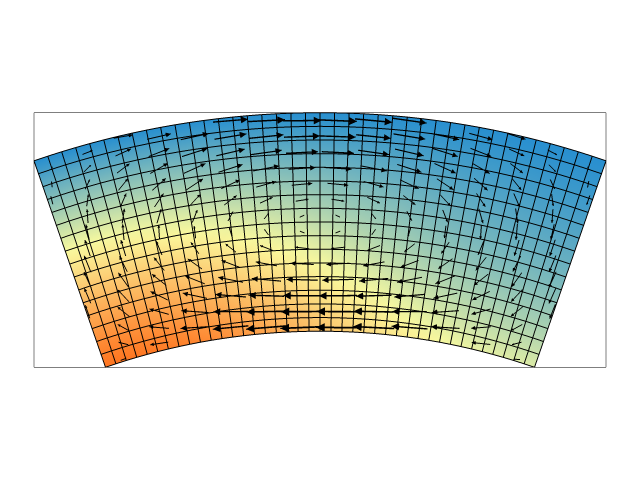

Attaching...
Done!
Fitted 2 variables to the figure.



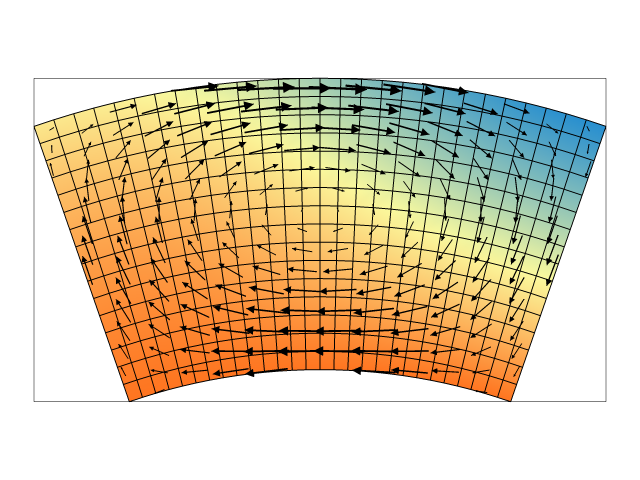

Attaching...
Done!
Fitted 2 variables to the figure.



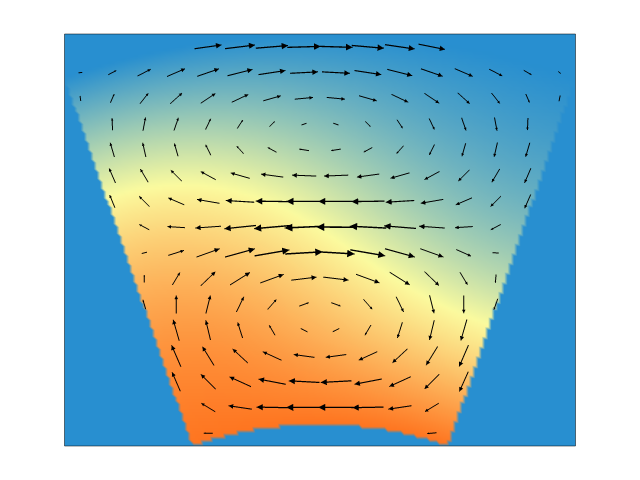

In [95]:
show_all()

Fitted 2 variables to the figure.



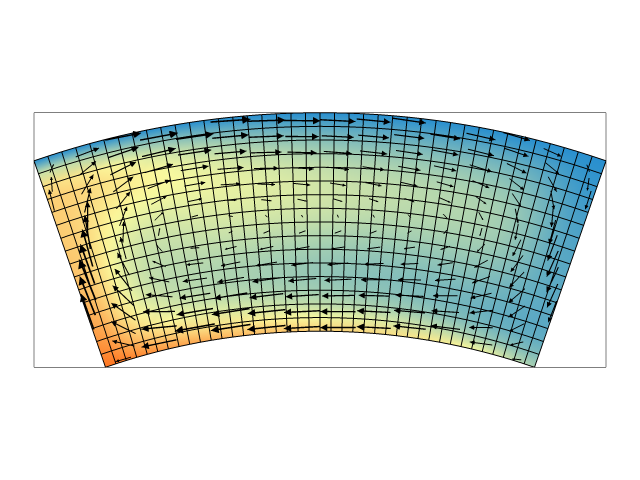

Fitted 2 variables to the figure.



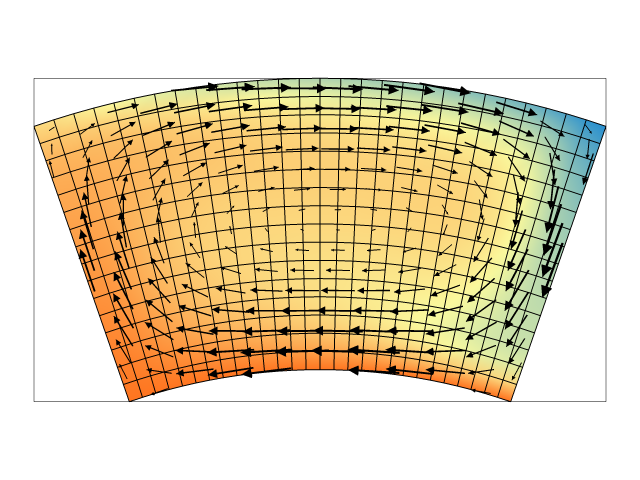

Fitted 2 variables to the figure.



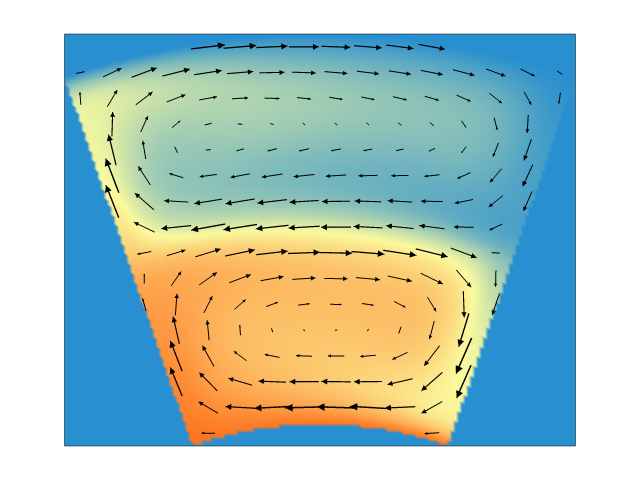

In [97]:
for i in range(100):
    systems.iterate()
show_all()

In [22]:
topVels = upperSys.velocityField.data[upperSys.outer]

In [23]:
radialComp = fn.math.dot(upperSys.velocityField, upperSys.mesh.unitvec_r_Fn).evaluate(upperSys.mesh.data[upperSys.outer])

In [24]:
topRadUnitVecs = upperSys.mesh.unitvec_r_Fn.evaluate(upperSys.mesh)[upperSys.outer]

In [25]:
topRotatedVecs = topRadUnitVecs * radialComp

In [26]:
# boundary_interpolate(
#     (lowerSys.velocityField, lowerSys.outer),
#     (upperSys.velocityField, upperSys.inner),
#     )

In [27]:
### SNIPPETS ###

In [28]:
# xs = np.linspace(self.mesh.data[:,0].min(), self.mesh.data[:,0].max(), 100)
# ys = np.linspace(self.mesh.data[:,1].min(), self.mesh.data[:,1].max(), 100)
# self.cartesianScope = np.array(np.meshgrid(xs, ys)).T.reshape([-1, 2])

In [29]:
# # nodewise system crosscom
# def update():
#     if len(sub_systems) > 1:
#         for index in range(len(sub_systems[:-1])):
#             lowerSysName, lowerSys = sub_systems[index]
#             upperSysName, upperSys = sub_systems[index + 1]
#             nodeRatio = int(len(upperSys.inner) / len(lowerSys.outer))
#             pairedNodes = list(zip(
#                 list(lowerSys.outer),
#                 list(upperSys.inner)[:: nodeRatio + 1]
#                 ))
#             for paired_index, (lowerSysNode, upperSysNode) in enumerate(pairedNodes):
#                 lowerSys.thermalFlux.data[lowerSysNode] = \
#                     upperSys.thermalFlux.data[upperSysNode]
#                 upperSys.temperatureField.data[upperSysNode] = \
#                     lowerSys.temperatureField.data[lowerSysNode]
#                 if paired_index < len(list(pairedNodes)) - 1: # the highest index
#                     previousVal = lowerSys.temperatureField.data[lowerSysNode]
#                     nextVal = lowerSys.temperatureField.data[
#                         pairedNodes[paired_index + 1][0]
#                         ]
#                     previousCoord = lowerSys.mesh.data[lowerSysNode]
#                     nextCoord = lowerSys.mesh.data[
#                         pairedNodes[paired_index + 1][0]
#                         ]
#                     maxDist = math.hypot(
#                         nextCoord[0] - previousCoord[0],
#                         nextCoord[1] - previousCoord[1]
#                         )
#                     maxDiff = nextVal - previousVal
#                     valGradient = maxDiff / maxDist
#                     for i in range(nodeRatio + 1)[1:]:
#                         node = list(upperSys.inner)[paired_index * (nodeRatio + 1) + i]
#                         currentCoord = upperSys.mesh.data[node]
#                         currentDist = math.hypot(
#                             nextCoord[0] - currentCoord[0],
#                             nextCoord[1] - currentCoord[1]
#                             )
#                         currentVal = previousVal + valGradient * currentDist
#                         upperSys.temperatureField.data[node] = currentVal